# Rain Prediction ANN

 ## This is the model predict Wheather in next day there will be rain or not

In [1]:
# import all libraries
import matplotlib.pyplot as plt # for visualisation
import seaborn as sns # for statistical visualisation
import datetime # for date and time
from sklearn.preprocessing import LabelEncoder # for encode the categorical value
from sklearn.preprocessing import StandardScaler # for scale the value to -3 to 3
from sklearn.model_selection import train_test_split # to split the dependent and independent variable to train and test set
# Dense: for conected layer to the neuron
# BatchNormalization: Normalizes the inputs of each layer to improve training stability and performance
# Droupout: Prevents overfitting by randomly dropping a fraction of neurons during training.
# LSTM: A layer for Long Short-Term Memory networks, designed for sequential data like time series, text, or audio.
from keras.layers import Dense, BatchNormalization, Dropout,LSTM 
from keras.models import Sequential #Used to define a linear stack of layers.
from keras.utils import to_categorical #Converts class labels (integers) into one-hot encoded vectors
from keras.optimizers import Adam # optimizer for ANN
from tensorflow.keras import regularizers # feature selection
from sklearn.metrics import precision_score, recall_score,confusion_matrix,classification_report,accuracy_score,f1_score
from keras import callbacks
import pandas as pd # for dataset
import numpy as np # for nD array

# remove warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the dataset
data=pd.read_csv(r"C:\Users\sunil\Downloads\weatherAUS.csv\weatherAUS.csv")

In [3]:
data.head() # head of dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### The dataset contains about 10 years of daily weather observations from different locations across Australia. Observations were drawn from numerous weather stations.

### In this project, I will use this data to predict whether or not it will rain the next day. There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not.

In [4]:
data.info() # information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## There are some missing values in the data set where both numeric and categorical value are missing

# Visualisaition for cleaning

In [5]:
# as our target value is raintomorrow will hapen r not 
# lets check wheather its balance or not

<Axes: xlabel='RainTomorrow', ylabel='count'>

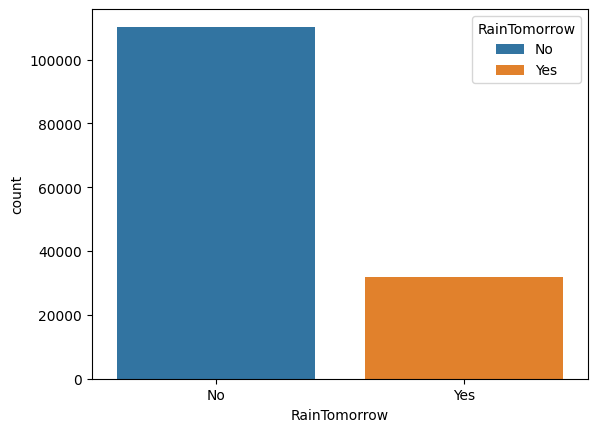

In [6]:
sns.countplot(x=data['RainTomorrow'],hue=data["RainTomorrow"])

<Axes: >

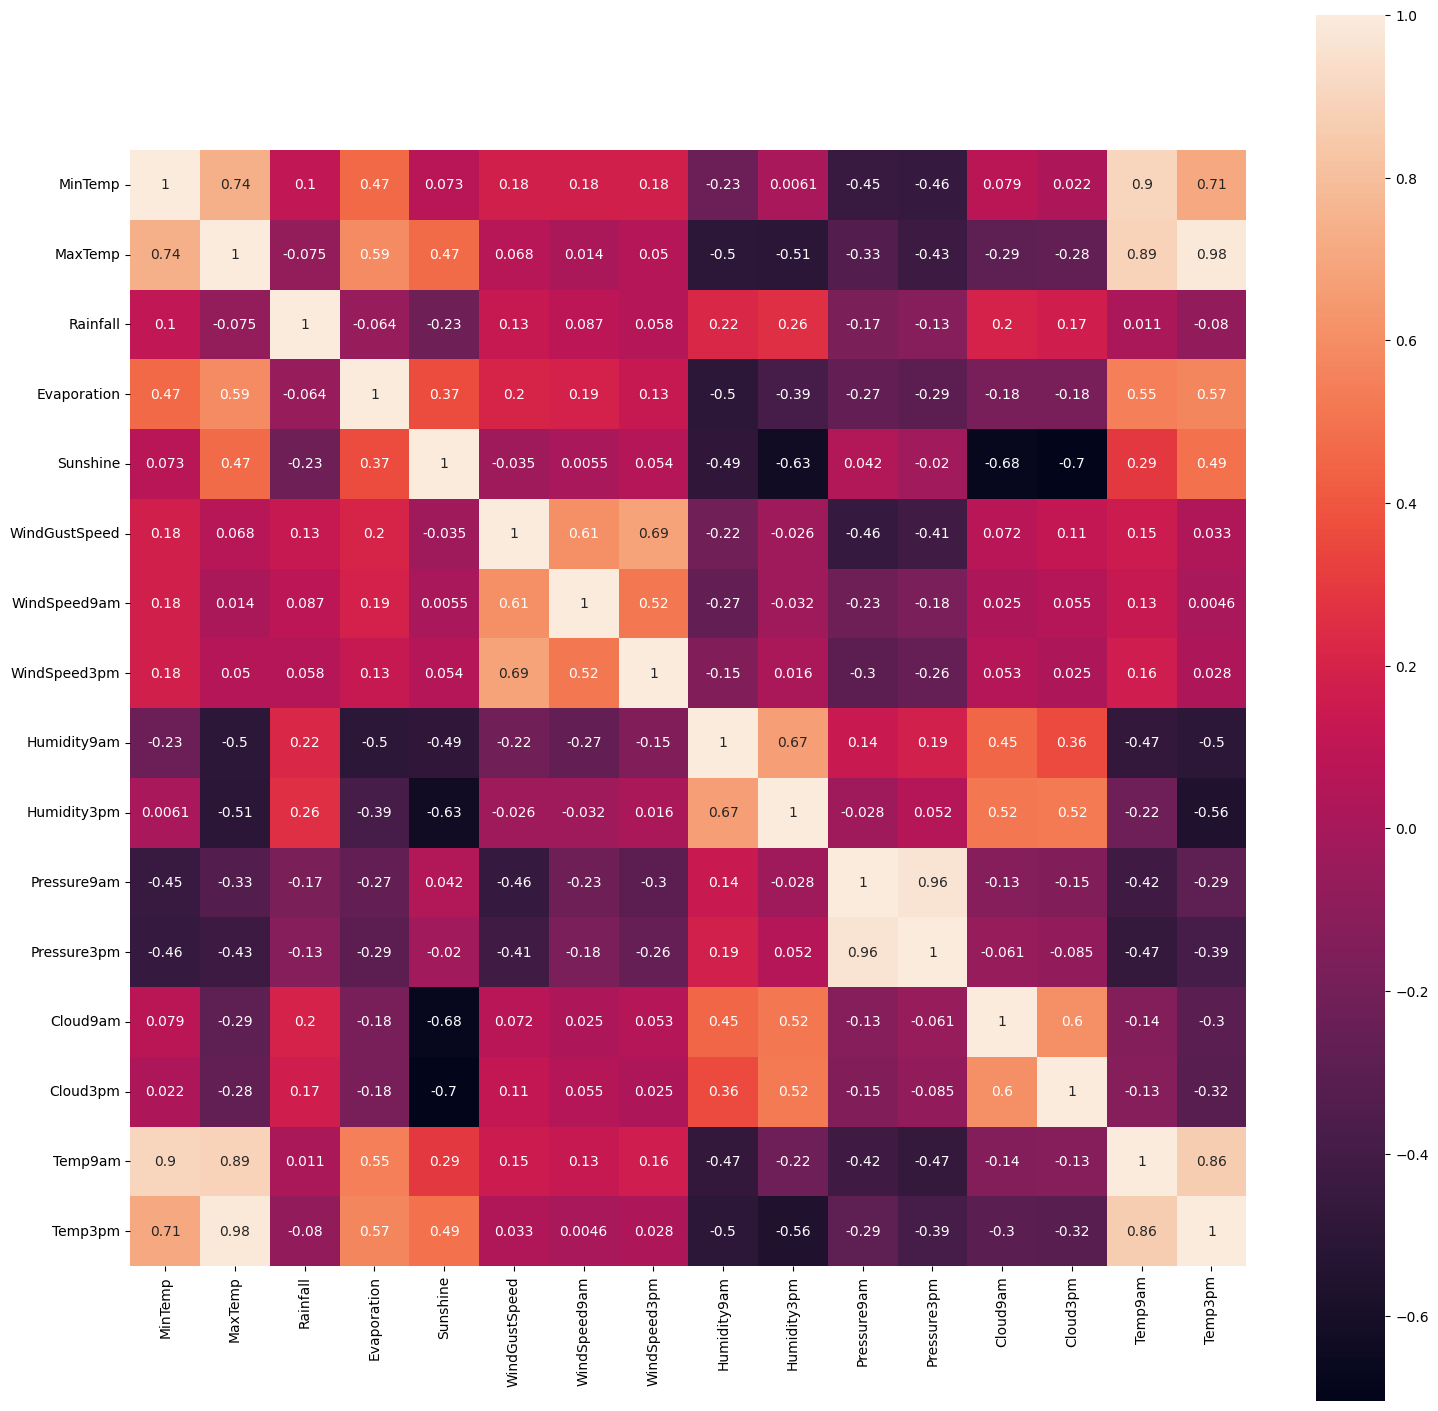

In [7]:
# take all numerical value one side to find the correlation between them
numeric_data=data[["MinTemp","MaxTemp","Rainfall","Evaporation","Sunshine","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Humidity9am",
                   "Humidity3pm","Pressure9am","Pressure3pm","Cloud9am","Cloud3pm","Temp9am","Temp3pm"]]
cor = numeric_data.corr() # find correlation
plt.subplots(figsize=(18,18)) # figure size 
sns.heatmap(cor,annot=True,square=True) # represnted by heat map

## Encode date to months and day sith sin and cos combination to get cyclic continous feature

In [8]:
# Parsing Date time
lengths = data["Date"].str.len()
lengths.value_counts()

Date
10    145460
Name: count, dtype: int64

In [9]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters. 
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature. 

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

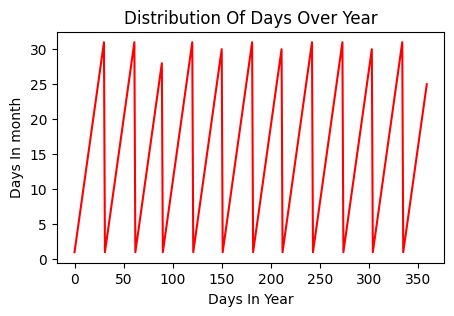

In [10]:
# roughly a year's span section 
section = data[:360] 
plt.subplots(figsize=(5,3))
tm = section["day"].plot(color="red")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

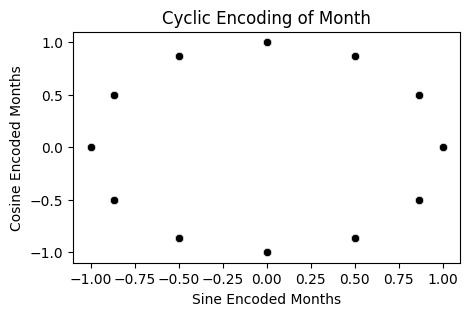

In [11]:
plt.subplots(figsize=(5,3))
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="black")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

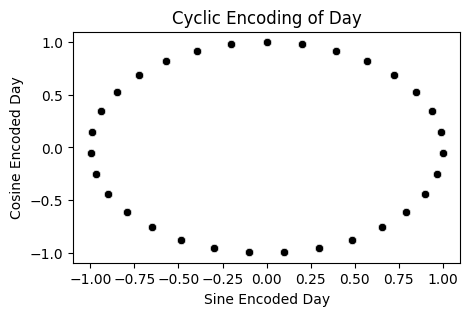

In [12]:
plt.subplots(figsize=(5,3))
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="black")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

# Deal with missing value in the dataset

## Categorical value missing treatments

In [13]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [14]:
# check  Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [15]:
# Filling missing values with mode of the column in value as categorical

for i in object_cols:
    data[i].fillna(data[i].mode()[0])

## Numeric value attribute in the dataste

In [16]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [17]:
# checking Missing values in numeric value attribute

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [18]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median())
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

## Successfully fill the missing value

# visualisation

<Axes: xlabel='year', ylabel='Rainfall'>

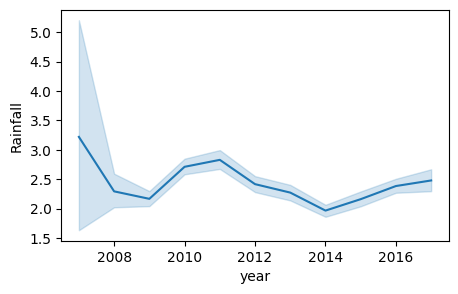

In [19]:
# line plot to see out year wise rain fall
plt.subplots(figsize=(5,3))
sns.lineplot(x=data["year"],y=data["Rainfall"])


<Axes: xlabel='year', ylabel='WindGustSpeed'>

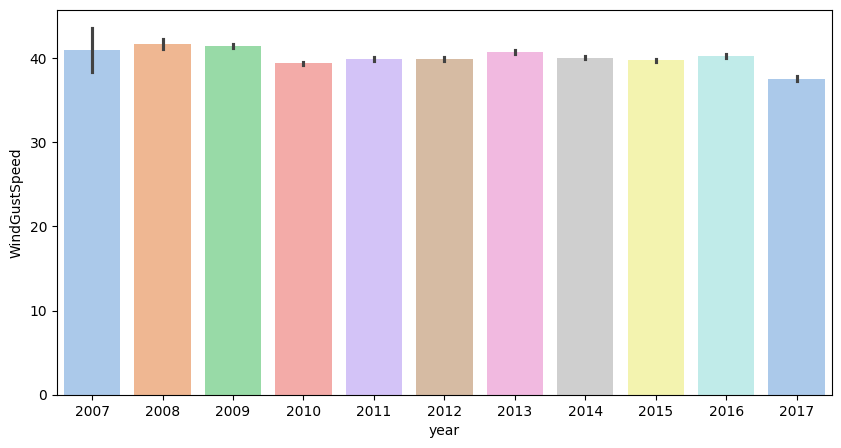

In [20]:
# wind speed by the year
plt.subplots(figsize=(10,5))
sns.barplot(x=data["year"],y=data["WindGustSpeed"],palette='pastel')

# Data preprocessing
  - Lable encoder
  - Scaling the data
  - Detecting outlier
  - Drop outlier

In [21]:
# LableEncoder
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int32         
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    145460 non-null  int32         
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     145460 non-null  int32         
 10  WindDir3pm     145460 non-null  int32         
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

In [22]:
# Scaling the data
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,7.815677e-18,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,143975.0,-3.790219e-16,1.000003,-3.234215,-0.717989,-0.030325,0.735483,3.392367
MaxTemp,144199.0,-1.387588e-16,1.000003,-3.936122,-0.747483,-0.087280,0.699345,3.494672
Rainfall,142199.0,6.875624e-17,1.000004,-0.278475,-0.278475,-0.278475,-0.184113,43.481692
Evaporation,82670.0,1.732738e-16,1.000006,-1.303922,-0.683942,-0.159343,0.460638,33.271926
Sunshine,75625.0,1.443165e-16,1.000007,-2.010636,-0.742625,0.208382,0.789554,1.819812
WindGustDir,145460.0,6.252542e-18,1.000003,-1.670768,-0.866215,0.139476,0.944029,1.547444
WindGustSpeed,135197.0,-1.731198e-16,1.000004,-2.501301,-0.664013,-0.076081,0.585343,6.979105
WindDir9am,145460.0,4.064152e-17,1.000003,-1.614034,-1.004491,0.011413,0.824137,1.636860
WindDir3pm,145460.0,-7.503050e-17,1.000003,-1.688306,-0.844398,-0.000489,0.843420,1.687329


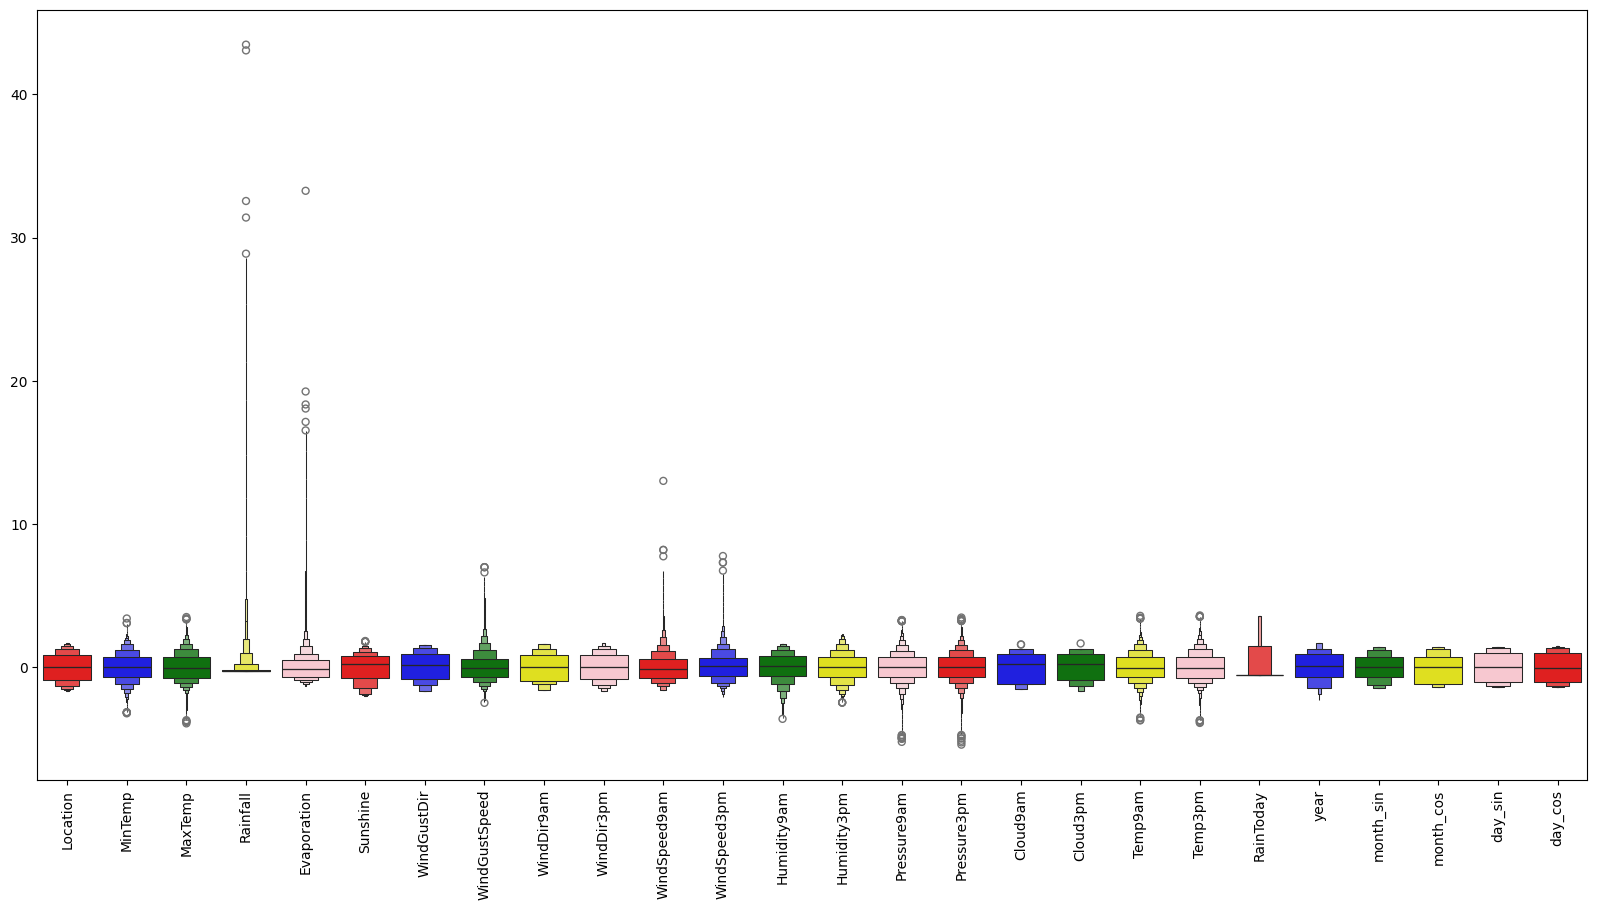

In [23]:
# Detecting outliers
#looking at the scaled features
colours = ["red", "blue", "green", "yellow", "pink"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()


In [24]:
# Drop outlier
#full data for 
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(52851, 27)

In [25]:
features.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos,RainTomorrow
6049,-0.96942,0.891770,1.682626,-0.278475,1.557527,1.238641,0.541753,0.585343,-1.410853,0.843420,...,0.180150,1.480932,1.689093,-0.53986,-1.485514,0.692529,1.245139,0.278970,1.426023,0
6050,-0.96942,0.969914,0.797673,-0.278475,2.225199,1.423559,-0.061662,-0.223064,0.417775,0.421466,...,-1.290253,0.510018,0.766455,-0.53986,-1.485514,0.692529,1.245139,0.549587,1.339551,0
6052,-0.96942,1.126201,2.019750,-0.278475,1.271382,0.789554,-0.665077,0.438360,-0.598129,-0.422443,...,0.547751,1.804570,1.905337,-0.53986,-1.485514,0.692529,1.245139,1.012774,1.011221,0
6053,-0.96942,1.516919,2.132125,-0.278475,1.414455,1.212224,1.145167,-0.664013,1.230499,1.476352,...,0.180150,1.866215,2.006251,-0.53986,-1.485514,0.692529,1.245139,1.186382,0.782805,0
6056,-0.96942,1.735721,1.514063,-0.278475,1.032928,1.317891,0.541753,0.070902,0.011413,0.421466,...,-1.290253,1.234351,1.415185,-0.53986,-1.485514,0.692529,1.245139,1.396744,-0.044639,0


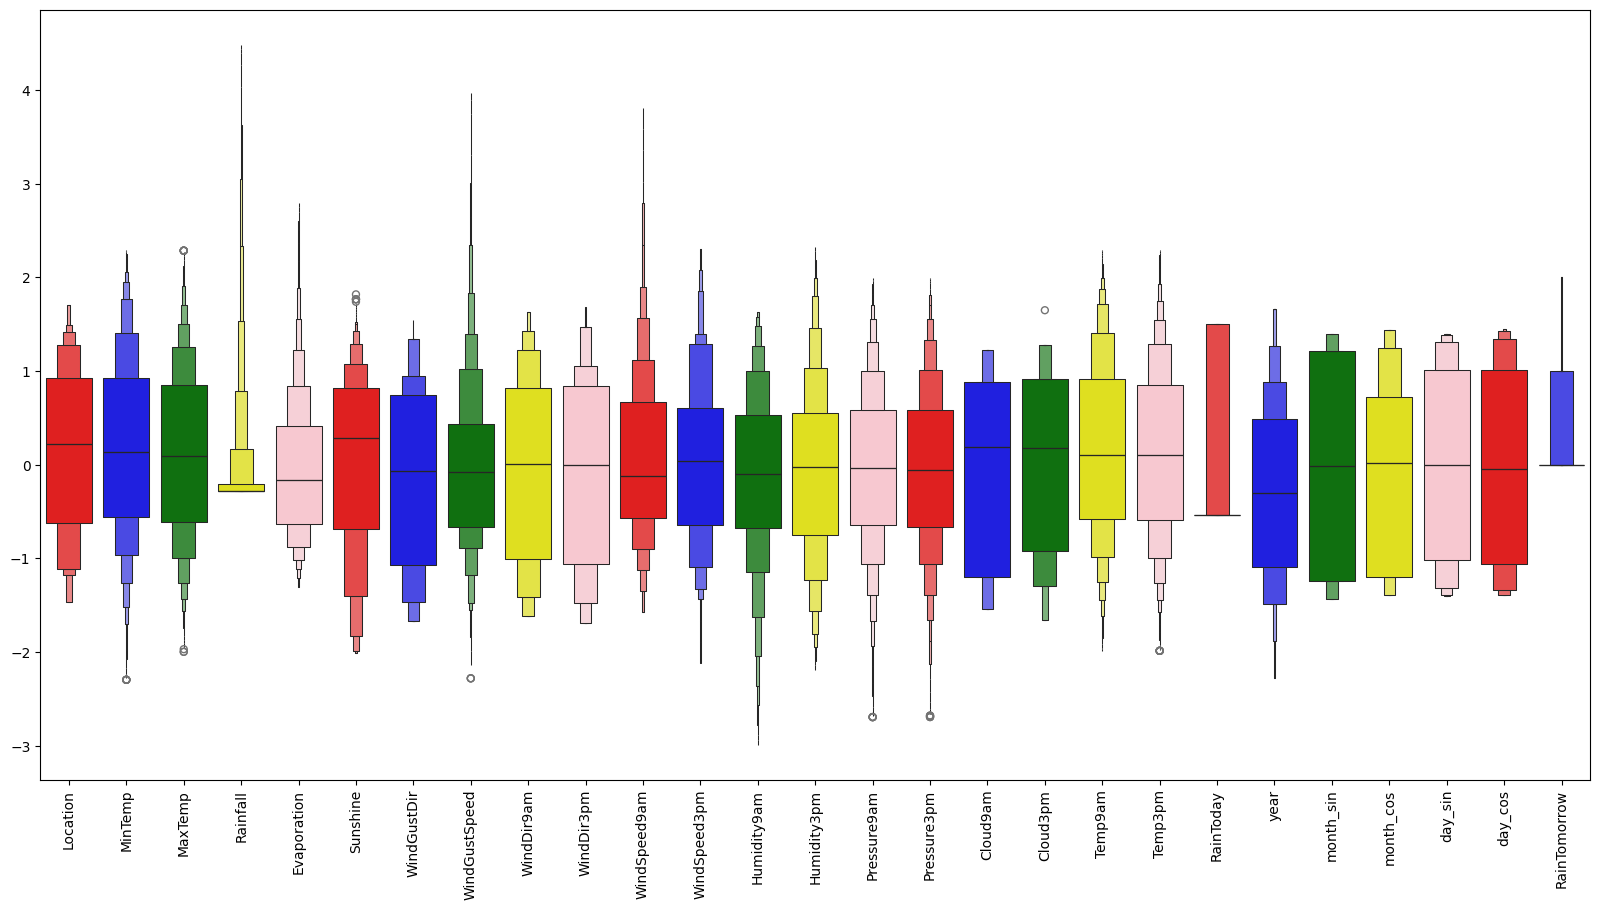

In [26]:
# visualise afer drop outlier
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

# Model building
 ## In this project, we build an artificial neural network.

## Following steps are involved in the model building

- Assining X and y the status of attributes and tags
- Splitting test and training sets
- Initialising the neural network
- Defining by adding layers
- Compiling the neural network
- Train the neural network

In [27]:
# dependent and independet variable
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X.shape

(52851, 26)

In [28]:
# Initialising the ANN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN with 15 epochs
history = model.fit(X_train, y_train, batch_size = 32, epochs = 15, validation_split=0.2)

Epoch 1/15
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7805 - loss: 0.6223 - val_accuracy: 0.7835 - val_loss: 0.3856
Epoch 2/15
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7817 - loss: 0.4125 - val_accuracy: 0.7835 - val_loss: 0.3747
Epoch 3/15
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7993 - loss: 0.4039 - val_accuracy: 0.8479 - val_loss: 0.3670
Epoch 4/15
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8142 - loss: 0.3956 - val_accuracy: 0.8491 - val_loss: 0.3615
Epoch 5/15
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8127 - loss: 0.3921 - val_accuracy: 0.8499 - val_loss: 0.3564
Epoch 6/15
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8104 - loss: 0.3910 - val_accuracy: 0.8512 - val_loss: 0.3507
Epoch 7/15
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8142 - loss: 0.3902 - val_accuracy: 0.8521 - val_loss: 0.3474
Epoch 8/15
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8191 - loss: 0.3759 - 

## Plotting training and validation loss over epochs

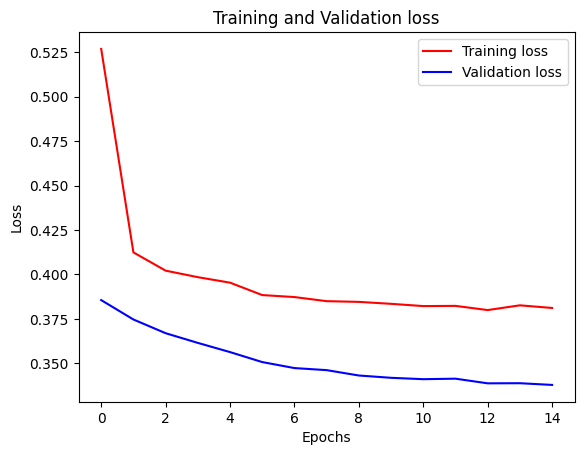

In [29]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "red", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"blue", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

## Plotting training and validation accuracy over epochs

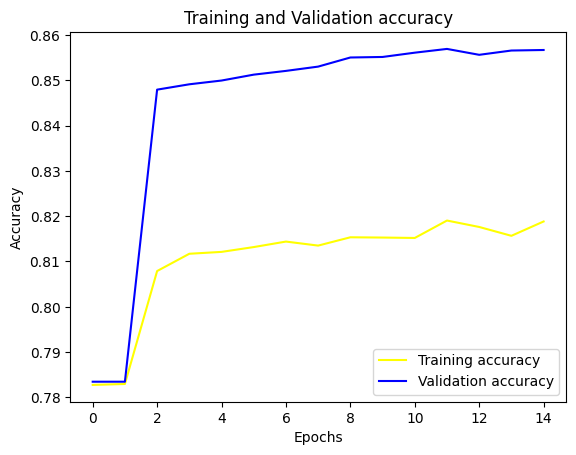

In [30]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "yellow", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "blue", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Conclusion
- Testing on the test set
- Evaluating the confusion matrix
- Evaluating the classification report
 

In [31]:

# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<Axes: >

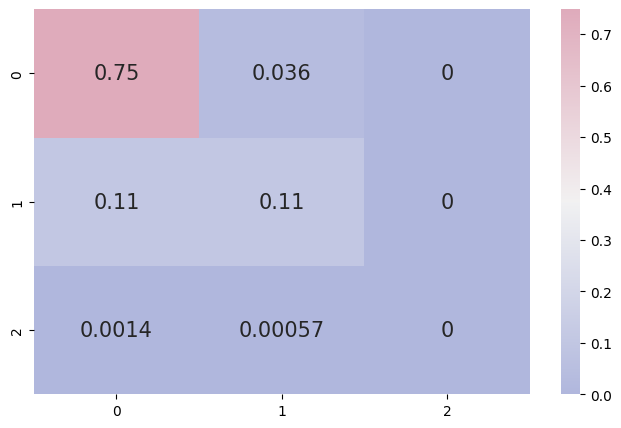

In [32]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(8,5))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8296
           1       0.75      0.51      0.60      2254
           2       0.00      0.00      0.00        21

    accuracy                           0.86     10571
   macro avg       0.54      0.49      0.51     10571
weighted avg       0.85      0.86      0.84     10571



## The model train with 85% accuracy

# complete